<a href="https://colab.research.google.com/github/BluBloos/QMIND2021-2022/blob/main/HandTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MOUNT GOOGLE DRIVE

In [ ]:
# TEST 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## test drive mount

In [ ]:
with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Hello Google Drive!

# TEST GPU AND RAM OF COLLAB INSTANCE

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# IMPORT LIBRARIES

In [ ]:
# import libraries
import os
import pickle
import matplotlib.pyplot as plt
import imageio
import numpy as np
import time
import math
#import libraries

# tensorflow things
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, MaxPool2D
from tensorflow.keras import Model
#tf.config.experimental.set_lms_enabled(True) # enable large model support.

#NOTE: Following along with -> https://www.tensorflow.org/tutorials/quickstart/advanced

import cv2 # opencv, for image resizing.

TensorFlow version: 2.7.0


# PARAMETERS

In [ ]:
IMAGE_SIZE = 320
GRAYSCALE = False
TRAIN_AMOUNT = 1000
TEST_AMOUNT = 100

# HELPER FUNCTIONS

In [ ]:
# Stole this function from Stackoverflow :)
def rgb2gray(rgb):
    return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=2)
def resize(img, size):
    return cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)

# STANDARD MODEL TEST

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
IMAGE_SIZE = 224

# USING A DIFFERENT MODEL + LOSS ARCHITECTURE THAT IS STANDARD 
# Leveraging https://www.tensorflow.org/tutorials/images/segmentation

# This is a pre-trained model.
# not including the fully connected layer at the top of the model.
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1 # little trick :)
model = unet_model(output_channels=OUTPUT_CLASSES)

'''model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
'''

# USING A DIFFERENT MODEL + LOSS ARCHITECTURE THAT IS STANDARD

"model.compile(optimizer='adam',\n              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n              metrics=['accuracy'])\n"

# MODEL DEFINITION

In [ ]:
def GenerateResidualModule():
    return [ Conv2D(16, 1, activation='relu', padding="same"), Conv2D(16, 3, activation='relu', padding="same"), Conv2D(32, 1, activation='relu', padding="same") ]

def GenerateHourglass():
    return [
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
        GenerateResidualModule(), 
    ]

class MyModel(Model):
    def __init__(self, modelName):
        super(MyModel, self).__init__()
        self._layers = [
            Conv2D(32, 7, activation='relu', input_shape=(320,320, 1), data_format="channels_last", padding="same"),
            GenerateResidualModule(),
            GenerateResidualModule(),
            GenerateHourglass(),
            GenerateResidualModule(),
            GenerateResidualModule(),
            Conv2D(21, 1, activation = 'relu', padding="same"), # 21 keypoints
            Conv2D(1, 1, padding="same"), # turn into probability density thing.
            MaxPool2D(),
            UpSampling2D()
        ]
        self.modelName = modelName
        
    def ResidualModuleForward(self, module, x, training=False):
        out = module[0](x)
        out = module[1](out)
        out = module[2](out)
        return out + x # This is the residual part lol. The skip connection.

    def HourglassForward(self, hourglass, x, training=False):
        maxpool = self._layers[8]
        upsample = self._layers[9]
        out = self.ResidualModuleForward(hourglass[0], x, training)
        skip1 = self.ResidualModuleForward(hourglass[1],out, training) # skip layer
        out = maxpool(out)
        out = self.ResidualModuleForward(hourglass[2],out, training)
        skip2 = self.ResidualModuleForward(hourglass[3],out, training) # skip layer
        out = maxpool(out)
        out = self.ResidualModuleForward(hourglass[4],out, training)
        skip3 = self.ResidualModuleForward(hourglass[5],out, training) # skip layer
        out = maxpool(out)
        out = self.ResidualModuleForward(hourglass[6],out, training)
        skip4 = self.ResidualModuleForward(hourglass[7],out, training) # skip layer
        out = maxpool(out)
        out = self.ResidualModuleForward(hourglass[8],out, training) # begin of 3 residual modules at small res.
        out = self.ResidualModuleForward(hourglass[9],out, training)
        out = self.ResidualModuleForward(hourglass[10],out, training)
        out = upsample(out) + skip4
        out = self.ResidualModuleForward(hourglass[11],out, training)
        out = upsample(out) + skip3
        out = self.ResidualModuleForward(hourglass[12],out, training)
        out = upsample(out) + skip2
        out = self.ResidualModuleForward(hourglass[13],out, training)
        out = upsample(out) + skip1
        out = self.ResidualModuleForward(hourglass[14],out, training)
        return out

    def call(self, x, training=False):
        x = self._layers[0](x)
        x = self.ResidualModuleForward(self._layers[1], x, training)
        skip = self.ResidualModuleForward(self._layers[2], x, training)
        x = self.HourglassForward(self._layers[3], skip, training)
        x = self.ResidualModuleForward(self._layers[4], x, training)
        x = self.ResidualModuleForward(self._layers[5], x, training)
        x = x + skip
        x = self._layers[6](x)
        return self._layers[7](x)

    def summary(self):
        print("Model: ", self.modelName)

model = MyModel("Aristotle")

In [ ]:
model.summary() # print out the model in a nice, clean format.

# DATA LOADING

## load in first image for redrawing pred after each epoch

In [ ]:

dir = '/content/drive/My Drive/RHD_small'
set = 'training'
path = os.path.join(dir, set)
image = imageio.imread(os.path.join(path, 'color', '%.5d.png' % 0)) 
_image = image.astype('float32')
if GRAYSCALE:
  _image = rgb2gray(_image / 255)
else:
  _image = image / 255
_image = resize(_image, IMAGE_SIZE)
_image = np.expand_dims(_image, axis=0 )
#print("_image", _image)
print("_image.shape", _image.shape)

_image.shape (1, 224, 224, 3)


## test and train image data load

In [ ]:
# LOAD IN THE DATA

if GRAYSCALE:
  x_train = np.zeros( (TRAIN_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, 1) )
  y_train = np.zeros( (TRAIN_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, 1) )
  x_test = np.zeros( (TEST_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, 1) ) 
  y_test = np.zeros( (TEST_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, 1) )
else:
  x_train = np.zeros( (TRAIN_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, 3) ) 
  y_train = np.zeros( (TRAIN_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, 1) )
  x_test = np.zeros( (TEST_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, 3) )
  y_test = np.zeros( (TEST_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, 1) )


def LoadData(dataAmount, dataType, np1, np2):
    path = os.path.join(dir, dataType)
    with open(os.path.join(path, 'anno_%s.pickle' % dataType), 'rb') as fi:
        anno_all = pickle.load(fi)

    count = 0 # count is the amount of data items that have been loaded thus far.
    for sample_id, anno in anno_all.items():
        image = imageio.imread(os.path.join(path, 'color', '%.5d.png' % sample_id))
        _image = image.astype('float32')
        if GRAYSCALE:
          _image = rgb2gray(_image / 255)
        else:
          _image = _image / 255

        # now we consider if the image is not the right size, and if this is the case
        # we scale it down to the right pixel size.
        # NOTE: WE WILL NOT SUPPORT UPSAMPLING.
        _image = resize(_image, IMAGE_SIZE)

        np1[count, :, :, :] = _image
        mask = imageio.imread(os.path.join(path, 'mask', '%.5d.png' % sample_id))
        # augment the mask
        mask[mask == 1] = 0
        mask[mask >= 2] = 255
        _mask = mask.astype('float32')
        _mask = _mask / 255

        # resize the mask
        _mask = resize(_mask, IMAGE_SIZE)

        np2[count, :, :, :] = np.expand_dims(_mask, axis=2)

        count += 1
        if (count >= dataAmount):
            break

print("Loading in the training data samples...")
start_time = time.time()
LoadData(TRAIN_AMOUNT, 'training', x_train, y_train)
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
end_time = time.time()
print('Elapsed for LoadData training', end_time - start_time, 's')
print("Loading in the evaluation data samples...")
start_time = time.time()
LoadData(TEST_AMOUNT, 'evaluation', x_test, y_test)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
end_time = time.time()
print('Elapsed for LoadData evaluation', end_time - start_time, 's')

Loading in the training data samples...
Elapsed for LoadData training 11.687358379364014 s
Loading in the evaluation data samples...
Elapsed for LoadData evaluation 1.1461782455444336 s


## test print one of the images from the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


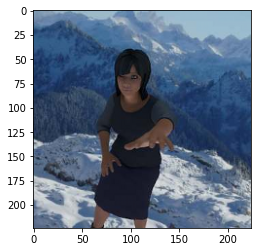

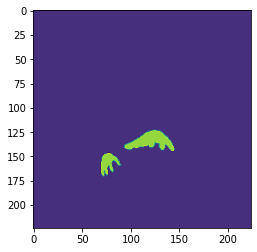

In [ ]:

_test = x_train[0] 
plt.imshow(_test)
plt.show()
_test = y_train[0]
plt.imshow(np.squeeze(_test))
plt.show()

## Batch the data for tensorflow.

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# TRAINING HELPER FUNCTIONS

In [ ]:
class StupidSimpleLossMetric():
    def __init__(self):
        self.losses = [] # empty python array 
    def __call__(self, loss):
        self.losses.append(loss)
    def result(self):
        return sum(self.losses) / len(self.losses)
    def reset_states(self):
        self.losses = []

optimizer = tf.keras.optimizers.Adam() # defaults should work just fine
train_loss = StupidSimpleLossMetric()
test_loss = StupidSimpleLossMetric()

# loss_fn = keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=False just means that the values are between zero and one (a probability).
loss_fn = lambda x, y: tf.math.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(x, y))

#train_accuracy = tf.keras.metrics.MeanAbsolutePercentageError(name='train_accuracy')
#test_accuracy = tf.keras.metrics.MeanAbsolutePercentageError(name='test_accuracy')

# @tf.function Compiles a function into a callable TensorFlow graph.
# https://www.tensorflow.org/guide/intro_to_graphs
def custom_loss_func(pred, labels):
    #return tf.math.reduce_sum( tf.math.square(labels - tf.cast(pred,tf.float64)))
    # now trying pixel-wise cross-entropy loss
    return -tf.math.reduce_sum(tf.math.log(pred) * labels)

@tf.function
def train_step(images, segmentation_masks):
    with tf.GradientTape() as tape:
        predictions = model(images)
        #loss = loss_func(predictions, segmentation_masks)
        #loss = np.dot(tf.reshape(segmentation_masks, [102400], tf.reshape(predictions, [102400])
        loss = loss_fn(segmentation_masks, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
    #train_accuracy(labels, predictions)
  
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  return loss_fn(predictions, labels)
  #test_accuracy(labels, predictions)

## loss function unit test


In [ ]:
# Just a quick test of the loss function (to make sure that it makes sense)!!!
input = tf.zeros([1, IMAGE_SIZE, IMAGE_SIZE, 1])  # mock pred of all zeros
label = np.expand_dims(y_train[0], axis=0)
loss = loss_fn(label, input)
print('Loss for pred of all zeros', loss.numpy())
loss2 = loss_fn(label, label)
print('Loss for perfect prediction', loss2.numpy())
input2 = tf.ones([1, IMAGE_SIZE, IMAGE_SIZE, 1])
loss3 = loss_fn(label, input2)
print('Loss for pred of all ones', loss3.numpy())

Loss for pred of all zeros 34779.293
Loss for perfect prediction 34456.727
Loss for pred of all ones 65044.227


# TRAINING LOOP

## load model params

In [ ]:
# TODO(Max): Write routine to load model params
model.load_weights(checkpoint_path)

## loop

Epoch 0
Epoch 1, Time 116.29009127616882 sLoss: 43625.581481933594, Test Loss: 834188.59765625, 


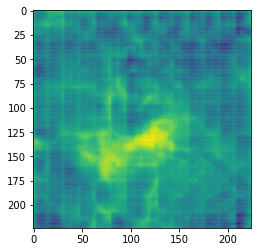

Epoch 1
Epoch 2, Time 116.44114089012146 sLoss: 39001.98483276367, Test Loss: 813290.0625, 


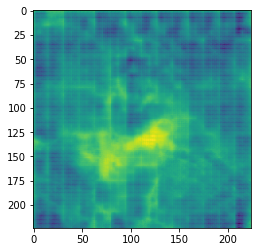

Epoch 2
Epoch 3, Time 115.90298581123352 sLoss: 37158.16784667969, Test Loss: 793288.8515625, 


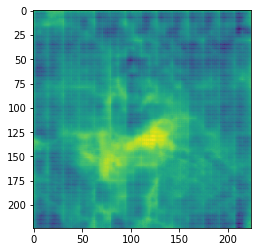

Epoch 3
Epoch 4, Time 115.94867372512817 sLoss: 36937.30029296875, Test Loss: 829764.29296875, 


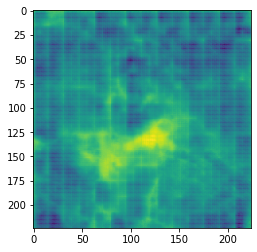

Epoch 4
Epoch 5, Time 116.90930485725403 sLoss: 35936.287048339844, Test Loss: 872731.40625, 


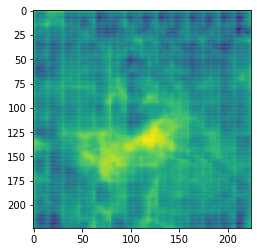

Epoch 5
Epoch 6, Time 118.73658013343811 sLoss: 36551.61358642578, Test Loss: 896845.796875, 


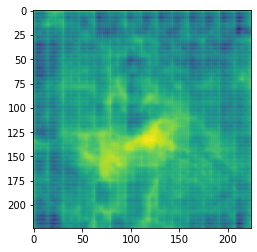

Epoch 6
Epoch 7, Time 117.25060725212097 sLoss: 40134.12292480469, Test Loss: 816603.1015625, 


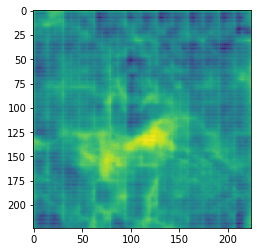

Epoch 7
Epoch 8, Time 116.34858393669128 sLoss: 36031.21969604492, Test Loss: 749972.0703125, 


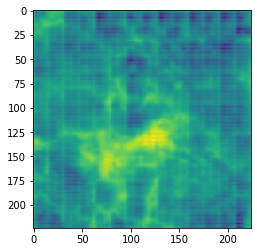

Epoch 8
Epoch 9, Time 116.54847264289856 sLoss: 43485.63757324219, Test Loss: 761133.23046875, 


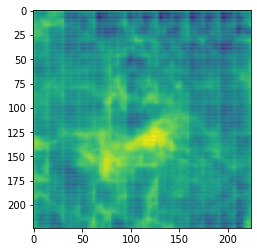

Epoch 9
Epoch 10, Time 117.70812153816223 sLoss: 49778.563873291016, Test Loss: 755177.234375, 


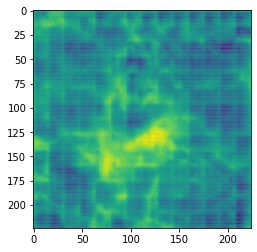

Epoch 10
Epoch 11, Time 117.57658433914185 sLoss: 54541.376953125, Test Loss: 862688.5, 


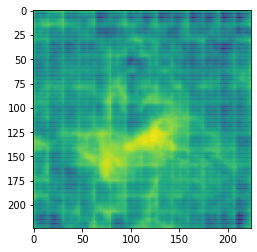

Epoch 11
Epoch 12, Time 118.07982230186462 sLoss: 37523.35470581055, Test Loss: 855944.3828125, 


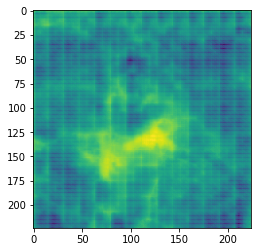

Epoch 12
Epoch 13, Time 118.57453751564026 sLoss: 29115.954483032227, Test Loss: 839993.4375, 


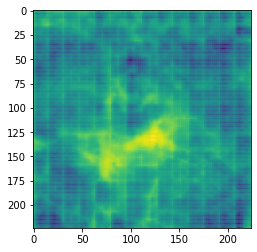

Epoch 13
Epoch 14, Time 117.73909020423889 sLoss: 26668.76319885254, Test Loss: 844641.46875, 


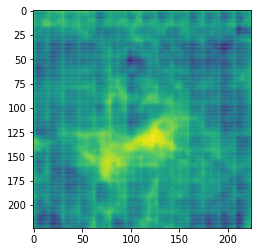

Epoch 14
Epoch 15, Time 117.17918086051941 sLoss: 24954.02816772461, Test Loss: 847050.05859375, 


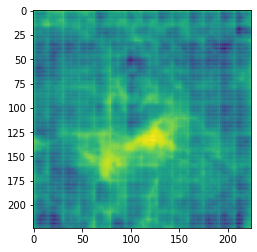

Epoch 15
Epoch 16, Time 117.08325266838074 sLoss: 23314.831665039062, Test Loss: 839200.0625, 


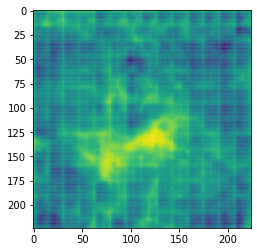

Epoch 16
Epoch 17, Time 117.01238322257996 sLoss: 21988.665588378906, Test Loss: 828267.0, 


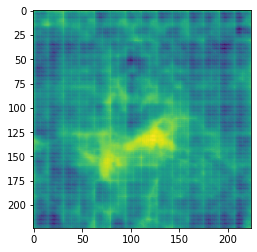

Epoch 17
Epoch 18, Time 116.82383394241333 sLoss: 20872.960037231445, Test Loss: 815737.84765625, 


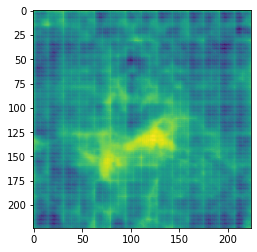

Epoch 18
Epoch 19, Time 116.63427639007568 sLoss: 20003.85922241211, Test Loss: 811924.734375, 


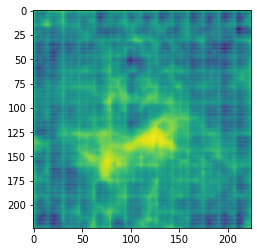

Epoch 19
Epoch 20, Time 116.16311717033386 sLoss: 19198.527557373047, Test Loss: 808425.65625, 


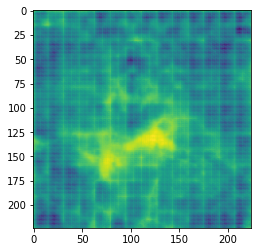

In [ ]:
EPOCHS = 20 # sure...

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Epoch", epoch)
  start = time.time()
  train_loss.reset_states()
  #train_accuracy.reset_states()
  test_loss.reset_states()
  #test_accuracy.reset_states()

  for images, labels in train_ds:
    loss = train_step(images, labels)
    train_loss(loss.numpy())

  for test_images, test_labels in test_ds:
    loss = test_step(test_images, test_labels)
    test_loss(loss.numpy())

  end = time.time()

  print(
    f'Epoch {epoch + 1}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
    f'Test Loss: {test_loss.result()}, '
  )

  # for each epoch, we want to show the 
  pred = model( _image )
  plt.imshow(np.squeeze(pred))
  plt.show()

## save model parameters

In [ ]:
save_dir = '/content/drive/My Drive'
checkpoint_path = save_dir + "/cp-{epoch:04d}.ckpt"
#model.save('current_model.h5py',save_path)
model.save_weights(checkpoint_path.format(epoch=40))

INFO:tensorflow:Assets written to: current_model.h5py/assets


## test model with select image from test set

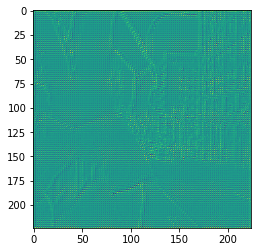

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


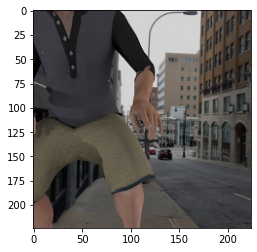

In [ ]:
# Testing the model with other training images...
dir = '/content/drive/My Drive/RHD_small'
set = 'evaluation'
path = os.path.join(dir, set)
IMAGE_NUM = 0
image = imageio.imread(os.path.join(path, 'color', '%.5d.png' % IMAGE_NUM)) 
_image = image.astype('float32')
if GRAYSCALE:
  _image = rgb2gray(_image / 255)
else:
  _image = _image / 255
_image = resize(_image, IMAGE_SIZE)
_image = np.expand_dims(_image, axis=0 )
pred = model( _image )
plt.imshow(np.squeeze(pred))
plt.show()
plt.imshow(np.squeeze(_image))
plt.show()

# SAVE CHANGES TO DRIVE AND UNMOUNT

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
